### Windsat training   
Training notebook with windsat dataset, to experiment with model architecture, sample selection an hyperparameters.

In [45]:
import matplotlib.pyplot as plt
import pickle

from datetime import datetime
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import sys
sys.path.append("../../")

from src.processing import windsat_datacube, create_landmask
from src.model import transform_batch, xy_split, plot_history

In [46]:
#Load the dataset from the folder
folder_path = "../../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path)
ds

<xarray.Dataset> Size: 3GB
Dimensions:         (day_number: 21, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 84B 1 2 3 4 5 6 7 ... 16 17 18 19 20 21
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, polarization
Data variables: (12/13)
    longitude       (day_number, longitude_grid) float32 121kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 60kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) int32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...              ...
    eaa             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 697MB dask.array<chunksize=(1, 1, 1, 240, 480, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, swath_sector) int32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [47]:
# Preprocess and select the dataset
landmask = create_landmask(lon=ds.lon.values, lat=ds.lat.values)
ds["landmask"] = (("latitude_grid", "longitude_grid"), landmask.values)

#I talked with maria and we can create a "snow mask" by filtering surtep_ERA5 > 2ºC

# Filter the dataset for land, then select the ascending pass
ascds = ds.where(ds.landmask == 0).sel(swath_sector=0)

# select data only where era5 surtep is avobe 2ºC
ascds = ascds.where(ascds.surtep_ERA5 >(273.15 + 2))

# Select only desired variables
variables = ["time","tbtoa", "surtep_ERA5"]
ascds = ascds[variables]

# Split tbtoa and time into polarization and frequency
ascds["tbtoa_18Ghz_V"] = ascds.tbtoa.sel(polarization=0,frequency_band=0)
ascds["tbtoa_18Ghz_H"] = ascds.tbtoa.sel(polarization=1,frequency_band=0)
ascds["tbtoa_37Ghz_V"] = ascds.tbtoa.sel(polarization=0,frequency_band=1)
ascds["tbtoa_37Ghz_H"] = ascds.tbtoa.sel(polarization=1,frequency_band=1)

ascds["time_18Ghz"] = ascds.time.sel(frequency_band=0)
ascds["time_37Ghz"] = ascds.time.sel(frequency_band=1)

# Drop the original dvars
ascds = ascds.drop_vars(names=["tbtoa","time"])

# Lat and lon should be dvars instead
ascds = ascds.reset_coords(names = ["lat","lon"])

# Add longitude_grid and latitude_grid as indeces 
ascds = ascds.assign_coords(latitude_grid=range(720), longitude_grid=range(1440))
ascds = ascds.set_index(latitude_grid='latitude_grid', longitude_grid='longitude_grid')
ascds

<xarray.Dataset> Size: 784MB
Dimensions:         (day_number: 21, latitude_grid: 720, longitude_grid: 1440)
Coordinates:
  * day_number      (day_number) int32 84B 1 2 3 4 5 6 7 ... 16 17 18 19 20 21
  * latitude_grid   (latitude_grid) int32 3kB 0 1 2 3 4 ... 715 716 717 718 719
  * longitude_grid  (longitude_grid) int32 6kB 0 1 2 3 4 ... 1436 1437 1438 1439
Data variables:
    surtep_ERA5     (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
    tbtoa_18Ghz_V   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_18Ghz_H   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_V   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_H   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    time_18Ghz      (day_number, latitude_grid, longitude_grid) float64 174MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    time_37Ghz      (day_number, latitude_grid, longitude_grid) float64 174MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

# Create the training dataset
Trust xarray and load all the data into a dataframe for training with keras


In [48]:
ascds_df = ascds.to_dataframe()
ascds_df.reset_index(inplace=True)
ascds_df.dropna(inplace=True)
ascds_df.drop(columns=["longitude_grid","latitude_grid"], inplace=True)
ascds_df = transform_batch(ascds_df)
ascds_df

,day_number,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz
212694,1,275.894440,-0.799947,0.959437,194.885010,127.485001,215.657501,163.107498,-0.498066,-0.498753
232835,1,276.849609,-0.761821,0.932796,211.529999,159.434998,230.509995,191.927490,-0.502751,-0.503454
232838,1,277.820099,-0.761821,0.937434,218.139999,172.832489,234.354996,200.334991,-0.502524,-0.503216
232839,1,278.050476,-0.761821,0.938944,217.937500,172.014999,234.285004,199.912506,-0.502455,-0.503140
232840,1,277.954346,-0.761821,0.940437,213.382492,163.179993,231.119995,193.644989,-0.502389,-0.503071
...,...,...,...,...,...,...,...,...,...,...
21661288,21,276.515686,0.943368,0.376629,202.862488,140.917496,215.862503,169.722504,-0.745851,-0.746355
21661289,21,275.758698,0.943368,0.380667,208.297485,151.820007,217.259995,175.607498,-0.745832,-0.746333
21705886,21,275.418823,0.979487,0.201505,196.614990,127.227493,208.505005,153.690002,-0.752623,-0.753145
21705887,21,275.177582,0.979487,0.205777,196.882492,127.707497,208.345001,153.547501,-0.752609,-0.753126


In [49]:
# Define a custom model to train:

def build_model():
    n_vars = ascds_df.shape[1] - 1 # dont count the prediction column.
    model = Sequential([
        Input((n_vars,)),
        BatchNormalization(),
        Dense(30,activation="linear", name = "hiddenLayer1"),
        Dense(20,activation="relu", name = "hiddenLayer2"),
        Dense(10,activation="relu", name = "hiddenLayer3"),
        Dense(1,activation="relu", name = "outputLayer")
    ])
    model.compile(
        optimizer = "adam",
        loss ="mse",
        metrics = ["mse"]
    )

    model.summary()

    return model

In [50]:
model =build_model()

# Pick the columns for training and test
X, y = xy_split(ascds_df)
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 13)

# Fit the model
callback = EarlyStopping(
    monitor = "loss",
    patience = 5,
    min_delta = 0.1,
    verbose=1,
    restore_best_weights = True
)

history = model.fit(
    x_train,
    y_train,
    epochs=100,
    validation_data=(x_test,y_test),
    callbacks=[callback]
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 9)              │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 30)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,177 (4.60 KB)

 Trainable params: 1,159 (4.53 KB)

 Non-trainable params: 18 (72.00 B)

Epoch 1/100
12512/12512 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - loss: 7500.8169 - mse: 7500.8169 - val_loss: 13.9420 - val_mse: 13.9420
Epoch 2/100
12512/12512 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - loss: 17.6197 - mse: 17.6197 - val_loss: 11.9295 - val_mse: 11.9295
Epoch 3/100
12512/12512 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - loss: 16.4462 - mse: 16.4462 - val_loss: 15.2688 - val_mse: 15.2688
Epoch 4/100
12512/12512 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - loss: 16.1355 - mse: 16.1355 - val_loss: 11.5117 - val_mse: 11.5117
Epoch 5/100
12512/12512 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - loss: 15.5169 - mse: 15.5169 - val_loss: 11.0042 - val_mse: 11.0042
Epoch 6/100
12512/12512 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - loss: 15.4458 - mse: 15.4458 - val_loss: 11.9418 - val_mse: 11.9418
Epoch 7/100
12512/12512 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - loss: 15.3462 - mse: 15.3462 - val_loss: 19.2513 - val_mse: 19.2513
Epoch 8/100
12512/12512 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - loss: 15.4284 - mse: 15.4284 - val_loss:

In [51]:
# Save FINAL model weights and history data.
now = datetime.now().strftime(r"%Y_%m_%dT%H%M%S")

weights_path = f"../../models/{now}.weights.h5"
model.save_weights(weights_path)

history_path = f"../../models/{now}_history.json"
with open(history_path, "wb") as file:
    pickle.dump(history, file)

(<Figure size 4800x2000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='mse [K]'>,
        <Axes: title={'center': 'Last 9 epochs'}, xlabel='Epoch', ylabel='mse [K]'>],
       dtype=object))

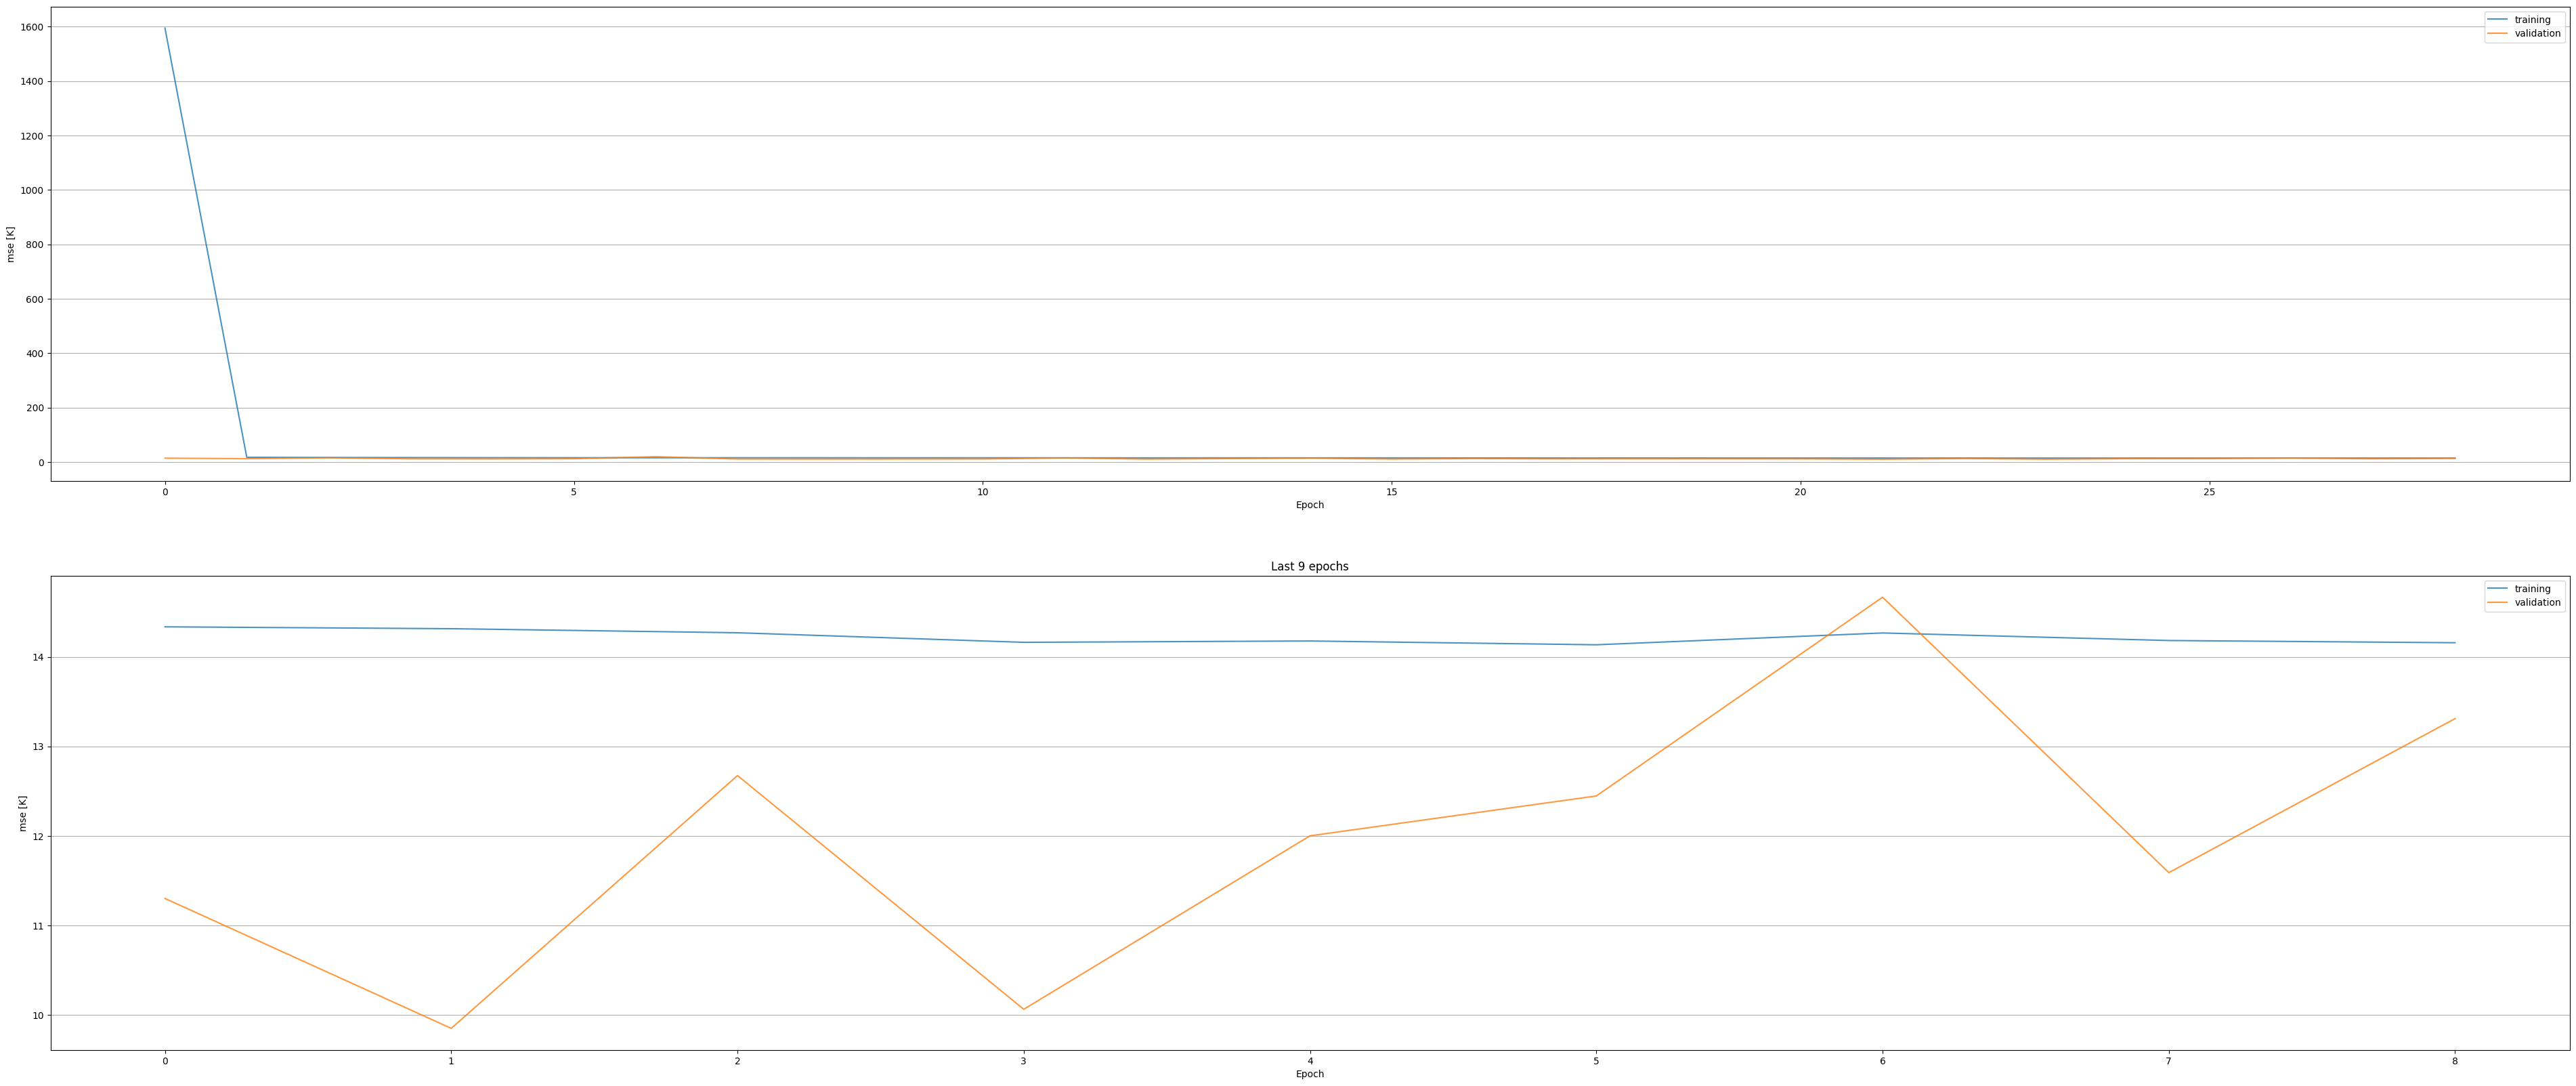

In [52]:
plot_history(history)

In [74]:
# Run the model using one day. Compute the loss and dismplay it on a map.
sample = ascds.sel(day_number=11)
sample_df = sample.to_dataframe()

sample_df.reset_index(inplace=True)
sample_df.dropna(inplace=True)
sample_df.drop(columns=["longitude_grid","latitude_grid"], inplace=True)
sample_df = transform_batch(sample_df)
X, y = xy_split(sample_df)

y_pred = model.predict(X)

sample_df = sample.to_dataframe()
sample_df.dropna(inplace=True)
sample_df["surtep_MODEL"] = y_pred
sample_df["error"] = sample_df["surtep_ERA5"] - sample_df["surtep_MODEL"]


700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step


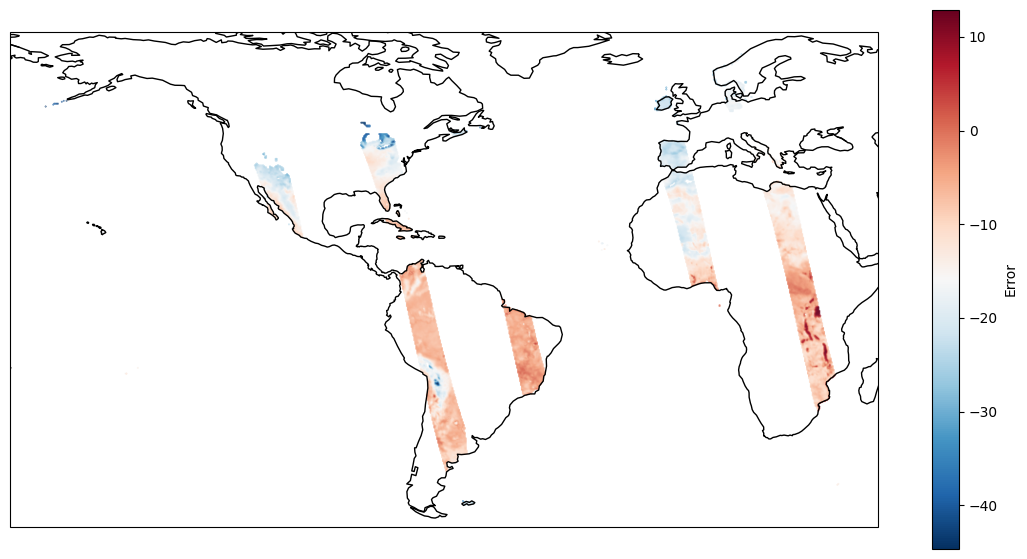

In [78]:
# Scatterplot of the data using lat and lon
import cartopy.crs as ccrs
fig, ax = plt.subplots(1,1,figsize=(14,7), subplot_kw={"projection":ccrs.PlateCarree()})
scatter = ax.scatter(x=sample_df["lon"], y=sample_df["lat"], c=sample_df["error"], cmap="RdBu_r", s=0.1)
ax.coastlines("110m")
plt.colorbar(scatter, ax=ax, orientation='vertical', label='Error')


# NEXT STEP

The model trains and the visualization is kin of nice. I need to run it with the full dataset.

My intuition is that we are not capturing the influence of day_number yet, since we only have 21 days (local dataset is biased)